# Model Training: 
### Part 3 >>> Predicting when a car will go to Pit Stops: Predicting the laps in which the drivers are going to stop for a pit stop.




In [66]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://media.giphy.com/media/MovqJSMROh1gA/giphy.gif") 

### Notebook Summary:



### 1) Importing Packages and Data

In [67]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import F1_Modelling_Extra_Functions # Internal package here used to evaluate models
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV #cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from tensorflow.keras import backend as K,utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.metrics import Precision
from tensorflow.keras.optimizers import SGD,Adam
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
# import joblib
import warnings



np.random.seed(1994)
pd.set_option('display.max_columns', None)
plt.figure(dpi=150)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=UserWarning)

<Figure size 960x720 with 0 Axes>

In [68]:
#The data stored in this path is obtained from ERGAST AND FASTF1 APIs (The files used to update and download the data are in the repo)

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
WeatherDF=pd.read_csv(path+"FASTF1_Weather.csv") #available only from 2018
LapsDF=pd.read_csv(path+"FASTF1_Laps.csv") #FAST F1 available only from 2018, Ergast from before but does not have compound data


C:\Users\gabri\AppData\Local\Temp\ipykernel_28492\3262076788.py:8: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  LapsDF=pd.read_csv(path+"FASTF1_Laps.csv") #FAST F1 available only from 2018, Ergast from before but does not have compound data


### 2) Data Preprocessing

In [69]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features
#   - null handling

ResultsDF=F1_Preprocessing.preprocess_Ergast_Results(ResultsDF,OneHotEncoder=True,HandleNulls=True)
PitsDF=F1_Preprocessing.preprocess_Ergast_Pits(PitsDF,OneHotEncoder=True)
WeatherDF=F1_Preprocessing.preprocess_FastF1_Weather(WeatherDF,OneHotEncoder=True)
LapsDF=F1_Preprocessing.preprocess_FastF1_Laps(LapsDF,OneHotEncoder=True)

from_season=2018

ResultsDF=ResultsDF[ResultsDF["season"]>=from_season]
PitsDF=PitsDF[PitsDF["season"]>=from_season]
WeatherDF=WeatherDF[WeatherDF["season"]>=from_season]
LapsDF=LapsDF[LapsDF["season"]>=from_season]

print(len(ResultsDF))
print(len(PitsDF))
print(len(WeatherDF))
print(len(LapsDF))

2879
3861
70243
392595


In [70]:
## Merging and filtering dataframes

# Filter only for race data
LapsDF=LapsDF[LapsDF["event_Race"]==1]
print(len(LapsDF))

# Add data from the pits
LapsDF=LapsDF.merge(ResultsDF[["driver.code","driverid"]].drop_duplicates(),left_on="driver",right_on="driver.code",how="left")
LapsDF["season-round-driverid"] = LapsDF["season"].astype(str) + LapsDF["round"].astype("str").str.zfill(2) + "-" + LapsDF["driverid"].astype(str)
PitsDF["pit_stop_lap_number_minus_1"]=PitsDF["pit_stop_lap_number"]-1
LapsDF=LapsDF.merge(PitsDF[["season-round-driverid","pit_stop_lap_number","pit_stop_lap_number_minus_1","pit_stop_number"]],left_on=["season-round-driverid","lapnumber"],right_on=["season-round-driverid","pit_stop_lap_number"],how="left")
LapsDF["is_pit_stop"]=np.where(LapsDF["pit_stop_lap_number"]>0,1,0)
LapsDF["is_next_lap_pit_stop"]=np.where(LapsDF["pit_stop_lap_number_minus_1"]>0,1,0)
print(len(LapsDF))

# Filtering rows to omit most flagged as innaccurate
LapsDF=LapsDF[~(((LapsDF["is_pit_stop"]==0)&(LapsDF["is_next_lap_pit_stop"]==0))&(LapsDF["isaccurate"]==0))]
print(len(LapsDF)) #og-(22702-3844) #138605

157463
157463
138605


In [ ]:
fill the na with the averages of the times
keep outliers


In [ ]:
# Handling time outliers
P_start = LapsDF['laptime_in_milliseconds'].quantile(0.01)
P_end = LapsDF['laptime_in_milliseconds'].quantile(0.99)
LapsDF[""] = LapsDF[]

In [60]:
LapsDF[LapsDF["laptime_in_milliseconds"]==0]["is_next_lap_pit_stop"].value_counts()

is_next_lap_pit_stop
0    186
1     55
Name: count, dtype: int64

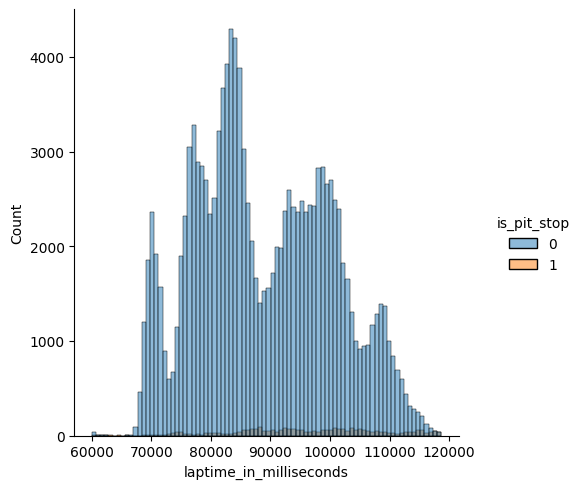

In [58]:
sns.displot(x="laptime_in_milliseconds",hue="is_pit_stop",data=DF)

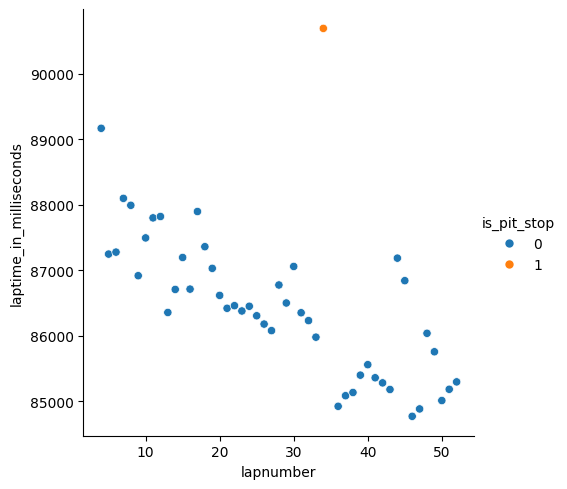

In [39]:
sns.relplot(y="laptime_in_milliseconds",x="lapnumber",data=LapsDF[LapsDF["season-round-event-driver"]=='201814-Race-GAS'],hue="is_pit_stop")

In [55]:
# LapsDF["len"]=LapsDF["laptime_clean"].apply(lambda x:len(x))
LapsDF[LapsDF["season-round-event"]=='201814-Race'].head(50)
# add when it is pit stop
# get rid of outlier times

,time,driver,drivernumber,laptime,lapnumber,stint,pitouttime,pitintime,sector1time,sector2time,sector3time,sector1sessiontime,sector2sessiontime,sector3sessiontime,speedi1,speedi2,speedfl,speedst,ispersonalbest,tyrelife,freshtyre,team,lapstarttime,lapstartdate,trackstatus,position,deleted,deletedreason,fastf1generated,isaccurate,season,round,season-round,season-round-driver,season-round-event,season-round-event-driver,laptime_in_milliseconds,sector1time_in_milliseconds,sector2time_in_milliseconds,sector3time_in_milliseconds,sector1sessiontime_in_milliseconds,sector2sessiontime_in_milliseconds,sector3sessiontime_in_milliseconds,num_laps_per_race,lapnumber_proportion,normalized_tyrelife,compound_cat,compound_HARD,compound_HYPERSOFT,compound_INTERMEDIATE,compound_MEDIUM,compound_SOFT,compound_SUPERSOFT,compound_TEST-UNKNOWN,compound_ULTRASOFT,compound_WET,event_Practice 1,event_Practice 2,event_Practice 3,event_Qualifying,event_Race,event_Sprint,event_Sprint Qualifying,event_Sprint Shootout,compound,event,driver.code,driverid,season-round-driverid,pit_stop_lap_number,pit_stop_lap_number_minus_1,pit_stop_number,is_pit_stop,is_next_lap_pit_stop
3,0 days 00:26:18.561000,GAS,10,0 days 00:01:29.166000,4.0,1.0,NaN,NaN,0 days 00:00:29.369000,0 days 00:00:30.811000,0 days 00:00:28.986000,0 days 00:25:18.757000,0 days 00:25:49.568000,0 days 00:26:18.554000,318.0,328.0,309.0,346.0,True,6.0,False,Toro Rosso,0 days 00:24:49.395000,NaN,1.0,11.0,False,NaN,False,True,2018,14,201814,201814-GAS,201814-Race,201814-Race-GAS,89166.0,29369.0,30811.0,28986.0,1518757.0,1549568.0,1578554.0,53.0,0.075472,0.064935,3.0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,SUPERSOFT,Race,GAS,gasly,201814-gasly,NaN,NaN,NaN,0,0
4,0 days 00:27:45.806000,GAS,10,0 days 00:01:27.245000,5.0,1.0,NaN,NaN,0 days 00:00:28.247000,0 days 00:00:29.853000,0 days 00:00:29.145000,0 days 00:26:46.801000,0 days 00:27:16.654000,0 days 00:27:45.799000,NaN,329.0,306.0,326.0,True,7.0,False,Toro Rosso,0 days 00:26:18.561000,NaN,1.0,11.0,False,NaN,False,True,2018,14,201814,201814-GAS,201814-Race,201814-Race-GAS,87245.0,28247.0,29853.0,29145.0,1606801.0,1636654.0,1665799.0,53.0,0.094340,0.077922,3.0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,SUPERSOFT,Race,GAS,gasly,201814-gasly,NaN,NaN,NaN,0,0
5,0 days 00:29:13.081000,GAS,10,0 days 00:01:27.275000,6.0,1.0,NaN,NaN,0 days 00:00:28.679000,0 days 00:00:29.785000,0 days 00:00:28.811000,0 days 00:28:14.478000,0 days 00:28:44.263000,0 days 00:29:13.074000,319.0,337.0,309.0,322.0,False,8.0,False,Toro Rosso,0 days 00:27:45.806000,NaN,1.0,12.0,False,NaN,False,True,2018,14,201814,201814-GAS,201814-Race,201814-Race-GAS,87275.0,28679.0,29785.0,28811.0,1694478.0,1724263.0,1753074.0,53.0,0.113208,0.090909,3.0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,SUPERSOFT,Race,GAS,gasly,201814-gasly,NaN,NaN,NaN,0,0
6,0 days 00:30:41.177000,GAS,10,0 days 00:01:28.096000,7.0,1.0,NaN,NaN,0 days 00:00:28.135000,0 days 00:00:30.291000,0 days 00:00:29.670000,0 days 00:29:41.209000,0 days 00:30:11.500000,0 days 00:30:41.170000,321.0,338.0,309.0,341.0,False,9.0,False,Toro Rosso,0 days 00:29:13.081000,NaN,1.0,12.0,False,NaN,False,True,2018,14,201814,201814-GAS,201814-Race,201814-Race-GAS,88096.0,28135.0,30291.0,29670.0,1781209.0,1811500.0,1841170.0,53.0,0.132075,0.103896,3.0,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,SUPERSOFT,Race,GAS,gasly,201814-gasly,NaN,NaN,NaN,0,0
7,0 days 00:32:09.167000,GAS,10,0 days 00:01:27.990000,8.0,1.0,NaN,NaN,0 days 00:00:28.420000,0 days 00:00:30.457000,0 days 00:00:29.113000,0 days 00:31:09.590000,0 days 00:31:40.047000,0 days 00:32:09.160000,331.0,341.0,312.0,336.0,False,10.0,False,Toro Rosso,0 days 00:30:41.177000,NaN,1.0,13.0,False,NaN,False,True,2018,14,201814,201814-GAS,201814-Race,201814-Race-GAS,87990.0,28420.0,30

In [ ]:
LapsDF.groupby("season-round-event-driver").agg('mean_lap_time')

In [ ]:
LapsDF["tyrelife"].unique()#[LapsDF["isaccurate"]==0][["season-driver-round"]].drop_duplicates()

array([nan,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36.,  1.,  2.,  3., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78.])

In [ ]:
#making a df with the pits in a season-round-driver level
#Deleting 7 rows where the number of pit stops is higher than 5
columns_from_original=PitsDF.drop(columns=["pit_stop_duration_in_milliseconds","pit_stop_number","pit_stop_lap_number",'pit_stop_time', 'pit_stop_duration']).columns
PitsDF=PitsDF[PitsDF["pit_stop_number"]<=4]

DF_CALCULATED=PitsDF.groupby(["season-round-driverid"]).agg(Total_Num_Pits=("pit_stop_number","max"),
                                              Total_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","sum"),
                                              Min_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","min"),
                                              Avg_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","mean"),
                                              Max_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","max"),
                                              Avg_PitStop_Lap_number=("pit_stop_lap_number","mean"),
                                              Min_PitStop_Lap_number=("pit_stop_lap_number","min"),
                                              Max_PitStop_Lap_number=("pit_stop_lap_number","max")).reset_index()

DF_PIVOT=PitsDF.pivot(index="season-round-driverid",columns=["pit_stop_number"],values=["pit_stop_lap_number","pit_stop_duration_in_milliseconds"]).reset_index()
DF_PIVOT.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in DF_PIVOT.columns]
DF_PIVOT=DF_PIVOT.rename(columns={"season-round-driverid_":"season-round-driverid"})

PitsDF_RACE_DRIVER_LEVEL=DF_CALCULATED.merge(DF_PIVOT,on="season-round-driverid",how="left").merge(PitsDF[columns_from_original].drop_duplicates(),how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))


2685


In [ ]:
####################################################################################################
#Prepare weather data at the start of the race to add to PitsDF_RACE_DRIVER_LEVEL df. 
print(WeatherDF["season-round"].nunique())
WeatherDF_StartRace=WeatherDF[(WeatherDF["event_Race"]==1)].groupby(["season-round"]).agg(MinTime=("time","min")).reset_index()
WeatherDF_StartRace=WeatherDF_StartRace.merge(WeatherDF[['time', 'airtemp', 'humidity', 'pressure', 'rainfall', 'tracktemp',
                                                         'winddirection', 'windspeed', 'season-round',
                                                         'season-round-event', 'normalized_airtemp', 'normalized_humidity',
                                                         'normalized_pressure', 'normalized_rainfall', 'normalized_tracktemp',
                                                         'normalized_winddirection', 'normalized_windspeed']],
                                                         on="season-round",how="right")
WeatherDF_StartRace=WeatherDF_StartRace[WeatherDF_StartRace["MinTime"]==WeatherDF_StartRace["time"]].drop(columns=["MinTime",'time'])
print(len(WeatherDF_StartRace))

####################################################################################################
#Prepare compound data at the start of the race to add to PitsDF_RACE_DRIVER_LEVEL df. 
print(len(LapsDF[["season-round","driver"]].drop_duplicates()))
Compounds_StartRace=LapsDF[(LapsDF["event_Race"]==1)].groupby(["season-round","driver"]).agg(MinTime=("time","min")).reset_index()
Compounds_StartRace=Compounds_StartRace.merge(LapsDF[['time','driver', 'drivernumber','tyrelife', 'freshtyre','season-round', 'normalized_tyrelife', 'compound_cat',
                                                         'compound_HARD', 'compound_HYPERSOFT', 'compound_INTERMEDIATE',
                                                         'compound_MEDIUM', 'compound_SOFT', 'compound_SUPERSOFT',
                                                         'compound_TEST-UNKNOWN', 'compound_ULTRASOFT', 'compound_WET','compound', 'event']],
                                                         on=["season-round","driver"],how="right")
Compounds_StartRace=Compounds_StartRace[Compounds_StartRace["MinTime"]==Compounds_StartRace["time"]].drop(columns=["MinTime",'time'])
print(len(Compounds_StartRace))

####################################################################################################
#Prepare Results data to add to PitsDF_RACE_DRIVER_LEVEL df.
selected_features_constructor_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_extra=["driver.code","constructor.name","driver.age_at_race","season-round-driverid"]
ResultsDF_to_pits=ResultsDF[selected_features_extra+selected_features_constructor_focused]
print(len(ResultsDF_to_pits))

####################################################################################################
#Merge with main df
PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(ResultsDF_to_pits,on="season-round-driverid",how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(WeatherDF_StartRace,on="season-round",how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(Compounds_StartRace,left_on=["season-round","driver.code"],right_on=["season-round","driver"],how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

#####################################################################################################
# Change format and exclude empty rows:

cols=['rainfall','freshtyre', 'compound_HARD','compound_HYPERSOFT', 'compound_INTERMEDIATE', 'compound_MEDIUM','compound_SOFT', 'compound_SUPERSOFT', 'compound_TEST-UNKNOWN','compound_ULTRASOFT', 'compound_WET']
PitsDF_RACE_DRIVER_LEVEL[cols]=PitsDF_RACE_DRIVER_LEVEL[cols].astype("float")

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["airtemp"].isna()] #keep all rows where weather data is available
PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["compound_cat"].isna()] #keep all rows where compound data is available
print(len(PitsDF_RACE_DRIVER_LEVEL))

144
144
2999
2874
2879
2685
2685
2685
2357


In [ ]:
# After the data analysis done, due to the compound data we filter the data to be from season 2019:
PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season"]>=2019] #2284

#due to low volumes for pits >3 we group them together in a category of 3+
PitsDF_RACE_DRIVER_LEVEL["Total_Num_Pits"]=np.where(PitsDF_RACE_DRIVER_LEVEL["Total_Num_Pits"]>3,3,PitsDF_RACE_DRIVER_LEVEL["Total_Num_Pits"])

### 3) Models

#### A. Predict Number of Pit stops
##### 1. Random Forest Classifier

In [ ]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['Total_Duration_Pits_milliseconds', 'Min_Duration_Pits_milliseconds','Avg_Duration_Pits_milliseconds', 'Max_Duration_Pits_milliseconds','Avg_PitStop_Lap_number', 'Min_PitStop_Lap_number',
       'Max_PitStop_Lap_number', 'pit_stop_lap_number_1','pit_stop_lap_number_2', 'pit_stop_lap_number_3','pit_stop_lap_number_4', 'pit_stop_duration_in_milliseconds_1','pit_stop_duration_in_milliseconds_2','pit_stop_duration_in_milliseconds_3','pit_stop_duration_in_milliseconds_4','season','round',
       'airtemp', 'humidity', 'pressure','rainfall', 'tracktemp', 'winddirection', 'windspeed','season-round-event','season-round-driverid', 'racename', 'circuit.circuitname','circuit.location.country', 'date', 'season-round', 'circuit.circuitid',
       'driverid', 'driver.code', 'constructor.name', 'driver', 'compound','event','compound_cat','drivernumber','tyrelife']
TEST_SEGMENTS=np.sort(PitsDF_RACE_DRIVER_LEVEL["season-round"].unique())[-15:]
TEST_DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='Total_Num_Pits'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

Test DF: 290
Train Validation DF: 1994


Best Estimator:  RandomForestClassifier(max_depth=20, min_samples_leaf=5)
Best Score:  0.3859524998343664


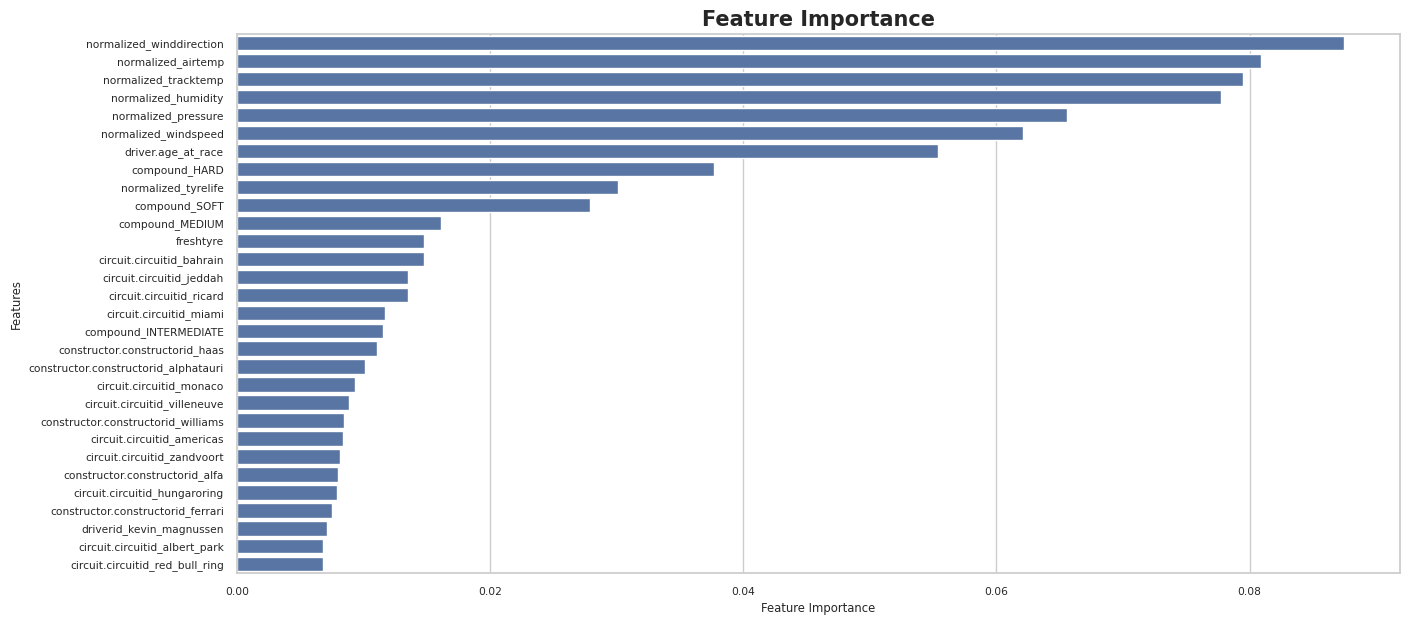

In [ ]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10,15,20],
    # 'min_samples_split': [5,10,15],
    'min_samples_leaf': [5,10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='f1_macro', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model_rfc=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=30,
                                                                            figuresize=(15,7))

Accuracy:  0.6517241379310345
F1-Score:  0.34433562621828023


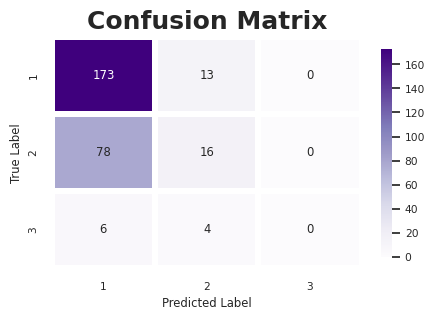

              precision    recall  f1-score   support

           1       0.67      0.93      0.78       186
           2       0.48      0.17      0.25        94
           3       0.00      0.00      0.00        10

    accuracy                           0.65       290
   macro avg       0.39      0.37      0.34       290
weighted avg       0.59      0.65      0.58       290



In [ ]:
# Try model in test set
y_pred_rfc = best_model_rfc.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred_rfc)
test_f1 = f1_score(y_test, y_pred_rfc, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1-Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred_rfc,figuresize=(5,3)) #confusion matrix and classification report

##### 2. Random Forest Classifier (PCA)

In [ ]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['Total_Duration_Pits_milliseconds', 'Min_Duration_Pits_milliseconds','Avg_Duration_Pits_milliseconds', 'Max_Duration_Pits_milliseconds','Avg_PitStop_Lap_number', 'Min_PitStop_Lap_number',
       'Max_PitStop_Lap_number', 'pit_stop_lap_number_1','pit_stop_lap_number_2', 'pit_stop_lap_number_3','pit_stop_lap_number_4', 'pit_stop_duration_in_milliseconds_1','pit_stop_duration_in_milliseconds_2','pit_stop_duration_in_milliseconds_3','pit_stop_duration_in_milliseconds_4','season','round',
       'airtemp', 'humidity', 'pressure','rainfall', 'tracktemp', 'winddirection', 'windspeed','season-round-event','season-round-driverid', 'racename', 'circuit.circuitname','circuit.location.country', 'date', 'season-round', 'circuit.circuitid',
       'driverid', 'driver.code', 'constructor.name', 'driver', 'compound','event','compound_cat','drivernumber','tyrelife']
TEST_SEGMENTS=np.sort(PitsDF_RACE_DRIVER_LEVEL["season-round"].unique())[-15:]
TEST_DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='Total_Num_Pits'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]

scaler = preprocessing.StandardScaler()
X_SCALED = scaler.fit_transform(X)
X_test_SCALED = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=16)  
X_pca = pca.fit_transform(X)
X_test_pca = pca.transform(X_test)

np.set_printoptions(suppress=True)
print('Explained variability per principal component (top 10): {}'.format(pca.explained_variance_ratio_[:10]))
print('All principal components hold: {} of the information'.format(sum(pca.explained_variance_ratio_)))

num_components = X_pca.shape[1]
column_names = [f'PC{i+1}' for i in range(num_components)] 
X_pca_df = pd.DataFrame(X_pca, columns=column_names)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=column_names)

Test DF: 290
Train Validation DF: 1994
Explained variability per principal component (top 10): [0.89048984 0.01301541 0.00656269 0.00439432 0.00405852 0.0039552
 0.00379611 0.00353354 0.00333732 0.00318264]
All principal components hold: 0.9513602574333097 of the information


In [ ]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = RandomForestClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'max_depth': [5,10,15,20],
    # 'min_samples_split': [5,10,15],
    'min_samples_leaf': [5,10,20,30,40]
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='f1_macro', return_train_score=True)
grid_search.fit(X_pca_df, y)

cv_results,best_model_rfc_pca=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X_pca_df,
                                                                            feature_importance_num_features=0,
                                                                            figuresize=(15,7))

Best Estimator:  RandomForestClassifier(max_depth=20, min_samples_leaf=10)
Best Score:  0.3579316419283232
-------------------------------------------------------------------------------------


Accuracy:  0.6413793103448275
F1-Score:  0.37441724941724946


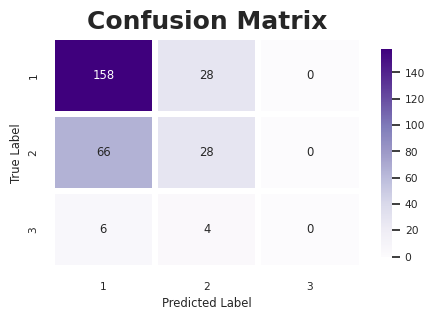

              precision    recall  f1-score   support

           1       0.69      0.85      0.76       186
           2       0.47      0.30      0.36        94
           3       0.00      0.00      0.00        10

    accuracy                           0.64       290
   macro avg       0.38      0.38      0.37       290
weighted avg       0.59      0.64      0.61       290



In [ ]:
# Try model in test set
y_pred_rfc_pca = best_model_rfc_pca.predict(X_test_pca_df)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred_rfc_pca)
test_f1 = f1_score(y_test, y_pred_rfc_pca, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1-Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred_rfc_pca,figuresize=(5,3)) #confusion matrix and classification report

##### 3. Support Vector Machines

In [ ]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['Total_Duration_Pits_milliseconds', 'Min_Duration_Pits_milliseconds','Avg_Duration_Pits_milliseconds', 'Max_Duration_Pits_milliseconds','Avg_PitStop_Lap_number', 'Min_PitStop_Lap_number',
       'Max_PitStop_Lap_number', 'pit_stop_lap_number_1','pit_stop_lap_number_2', 'pit_stop_lap_number_3','pit_stop_lap_number_4', 'pit_stop_duration_in_milliseconds_1','pit_stop_duration_in_milliseconds_2','pit_stop_duration_in_milliseconds_3','pit_stop_duration_in_milliseconds_4','season','round',
       'airtemp', 'humidity', 'pressure','rainfall', 'tracktemp', 'winddirection', 'windspeed','season-round-event','season-round-driverid', 'racename', 'circuit.circuitname','circuit.location.country', 'date', 'season-round', 'circuit.circuitid',
       'driverid', 'driver.code', 'constructor.name', 'driver', 'compound','event','compound_cat','drivernumber','tyrelife']
TEST_SEGMENTS=np.sort(PitsDF_RACE_DRIVER_LEVEL["season-round"].unique())[-15:]
TEST_DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='Total_Num_Pits'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]


Test DF: 290
Train Validation DF: 1994


In [ ]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = SVC(class_weight='balanced')

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'C': [0.01,0.1 ,1, 10, 100],  
    'kernel': ['linear', 'rbf','poly'], 
    'gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='f1_macro', return_train_score=True)
grid_search.fit(X_pca_df, y)

cv_results,best_model_svm=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X_pca_df,
                                                                            feature_importance_num_features=0,
                                                                            figuresize=(15,7))

Best Estimator:  SVC(C=100, class_weight='balanced', gamma='auto')
Best Score:  0.35983119297252336
-------------------------------------------------------------------------------------


Accuracy:  0.5448275862068965
F1-Score:  0.34946877172078245


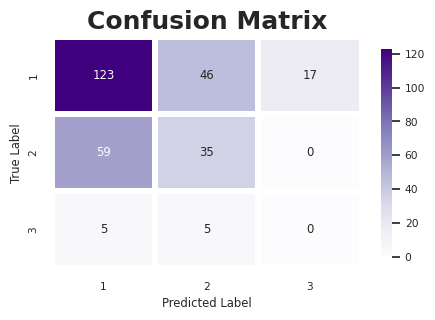

              precision    recall  f1-score   support

           1       0.66      0.66      0.66       186
           2       0.41      0.37      0.39        94
           3       0.00      0.00      0.00        10

    accuracy                           0.54       290
   macro avg       0.35      0.34      0.35       290
weighted avg       0.55      0.54      0.55       290



In [ ]:
# Try model in test set
y_pred_svm = best_model_svm.predict(X_test_pca_df)

# Metrics
test_accuracy = accuracy_score(y_test, y_pred_svm)
test_f1 = f1_score(y_test, y_pred_svm, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1-Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test,y_pred_svm,figuresize=(5,3)) #confusion matrix and classification report

##### 4. XGBoost

In [ ]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['Total_Duration_Pits_milliseconds', 'Min_Duration_Pits_milliseconds','Avg_Duration_Pits_milliseconds', 'Max_Duration_Pits_milliseconds','Avg_PitStop_Lap_number', 'Min_PitStop_Lap_number',
       'Max_PitStop_Lap_number', 'pit_stop_lap_number_1','pit_stop_lap_number_2', 'pit_stop_lap_number_3','pit_stop_lap_number_4', 'pit_stop_duration_in_milliseconds_1','pit_stop_duration_in_milliseconds_2','pit_stop_duration_in_milliseconds_3','pit_stop_duration_in_milliseconds_4','season','round',
       'airtemp', 'humidity', 'pressure','rainfall', 'tracktemp', 'winddirection', 'windspeed','season-round-event','season-round-driverid', 'racename', 'circuit.circuitname','circuit.location.country', 'date', 'season-round', 'circuit.circuitid',
       'driverid', 'driver.code', 'constructor.name', 'driver', 'compound','event','compound_cat','drivernumber','tyrelife']
TEST_SEGMENTS=np.sort(PitsDF_RACE_DRIVER_LEVEL["season-round"].unique())[-15:]
TEST_DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='Total_Num_Pits'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]-1

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]-1


Test DF: 290
Train Validation DF: 1994


Best Estimator:  XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Best Score:  0.615351192050478


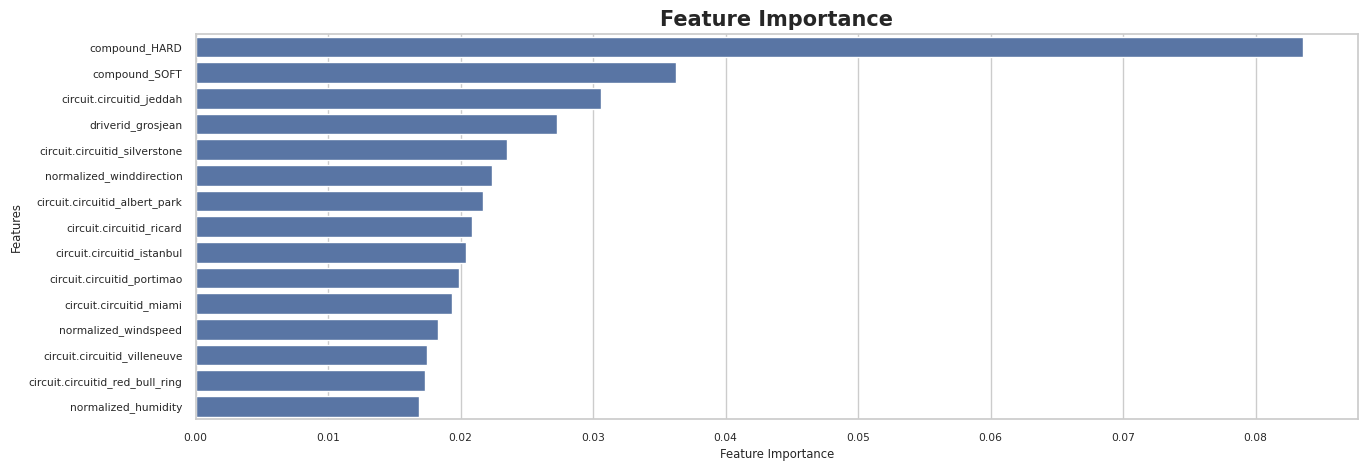

In [ ]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = XGBClassifier()

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'booster':['gbtree','dart'],
    'max_depth': [5,10],
    'eta':[0.01],
    # 'alpha':[0.1],
    # 'lambda':[1],
    }

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=scoring, cv=skf, refit='accuracy', return_train_score=True)
grid_search.fit(X, y)

cv_results,best_model_xgb=F1_Modelling_Extra_Functions.grid_search_show_results(gs=grid_search,
                                                                            X_df=X,
                                                                            feature_importance_num_features=15,
                                                                            figuresize=(15,5))



Accuracy:  0.6206896551724138
F1 Score:  0.35899096764906974


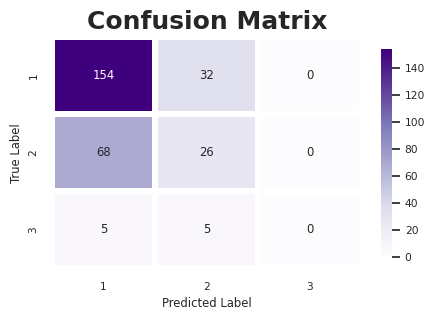

              precision    recall  f1-score   support

           1       0.68      0.83      0.75       186
           2       0.41      0.28      0.33        94
           3       0.00      0.00      0.00        10

    accuracy                           0.62       290
   macro avg       0.36      0.37      0.36       290
weighted avg       0.57      0.62      0.59       290



In [ ]:
# Try model in test set
y_pred_xgb = best_model_xgb.predict(X_test)

# Metrics
test_accuracy = accuracy_score(y_test+1, y_pred_xgb+1)
test_f1 = f1_score(y_test+1, y_pred_xgb+1, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test+1,y_pred_xgb+1,figuresize=(5,3)) #confusion matrix and classification report

##### 5. MLP

In [ ]:
# SPLIT TRAIN, VALIDATION AND TEST DFs
# I want to predict with the final_position of the last F1 rounds
EXCLUDED_COLS=['Total_Duration_Pits_milliseconds', 'Min_Duration_Pits_milliseconds','Avg_Duration_Pits_milliseconds', 'Max_Duration_Pits_milliseconds','Avg_PitStop_Lap_number', 'Min_PitStop_Lap_number',
       'Max_PitStop_Lap_number', 'pit_stop_lap_number_1','pit_stop_lap_number_2', 'pit_stop_lap_number_3','pit_stop_lap_number_4', 'pit_stop_duration_in_milliseconds_1','pit_stop_duration_in_milliseconds_2','pit_stop_duration_in_milliseconds_3','pit_stop_duration_in_milliseconds_4','season','round',
       'airtemp', 'humidity', 'pressure','rainfall', 'tracktemp', 'winddirection', 'windspeed','season-round-event','season-round-driverid', 'racename', 'circuit.circuitname','circuit.location.country', 'date', 'season-round', 'circuit.circuitid',
       'driverid', 'driver.code', 'constructor.name', 'driver', 'compound','event','compound_cat','drivernumber','tyrelife']
TEST_SEGMENTS=np.sort(PitsDF_RACE_DRIVER_LEVEL["season-round"].unique())[-15:]
TEST_DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)
TRAINING_VALIDATION_DF=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["season-round"].isin(TEST_SEGMENTS)].drop(columns=EXCLUDED_COLS)

print("Test DF:",len(TEST_DF))
print("Train Validation DF:",len(TRAINING_VALIDATION_DF))

TARGET='Total_Num_Pits'
X = TRAINING_VALIDATION_DF.drop(columns=[TARGET])
y = TRAINING_VALIDATION_DF[TARGET]-1

X_test = TEST_DF.drop(columns=[TARGET])
y_test = TEST_DF[TARGET]-1

scaler = preprocessing.StandardScaler()
X_SCALED = scaler.fit_transform(X)
X_test_SCALED = scaler.transform(X_test)

Test DF: 290
Train Validation DF: 1994


In [ ]:
#  MLP structure to go through cross validation
def create_mlp(learning_rate=0.001, units_d1=64, units_d2=32,drop_rate=0.3):
    model = Sequential()
    model.add(Dense(units=units_d1, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dropout(drop_rate))
    # model.add(Dense(units=units_d2, activation='relu'))
    # model.add(Dropout(drop_rate))
    model.add(Dense(PitsDF_RACE_DRIVER_LEVEL[TARGET].nunique(), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

>>>>>>>>>> LR: 0.0005  | U1: 5  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3651294641902757


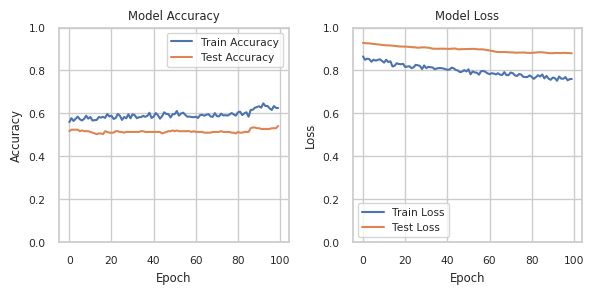

>>>>>>>>>> LR: 0.0005  | U1: 5  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3636801556292497


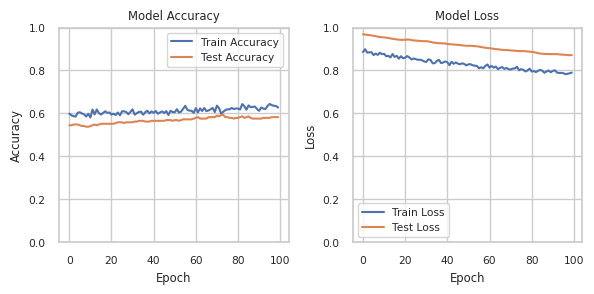

>>>>>>>>>> LR: 0.0005  | U1: 5  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3634751514755338


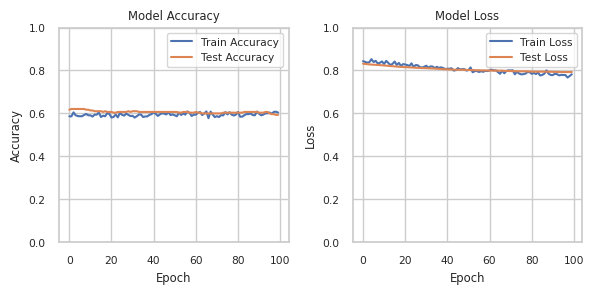

>>>>>>>>>> LR: 0.0005  | U1: 6  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.30860649052115036


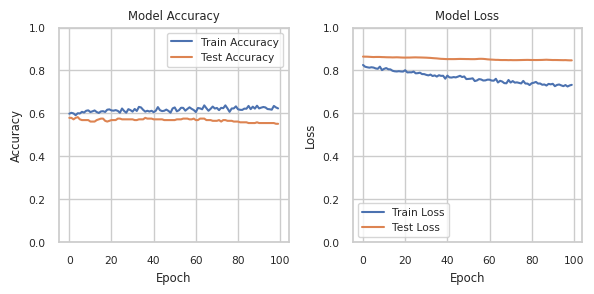

>>>>>>>>>> LR: 0.0005  | U1: 6  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3471334946170931


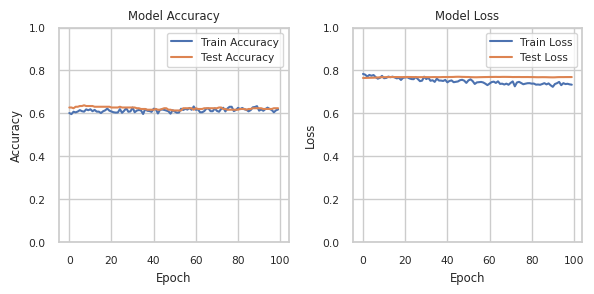

>>>>>>>>>> LR: 0.0005  | U1: 6  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.381707801647125


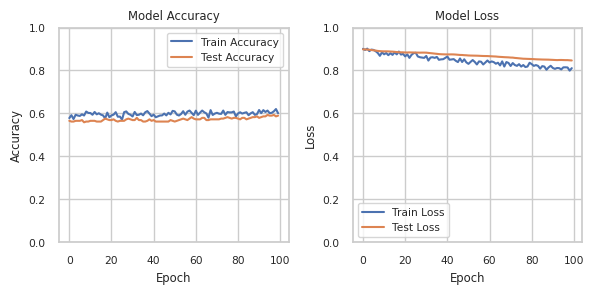

>>>>>>>>>> LR: 0.0005  | U1: 7  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.36692683313040103


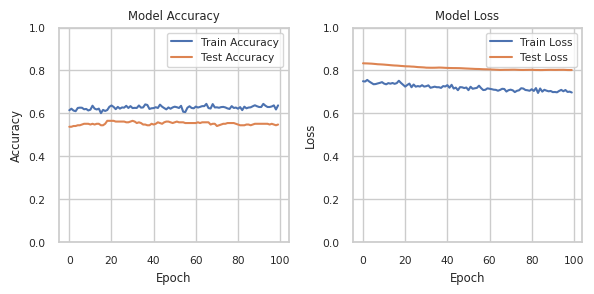

>>>>>>>>>> LR: 0.0005  | U1: 7  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3564568518815082


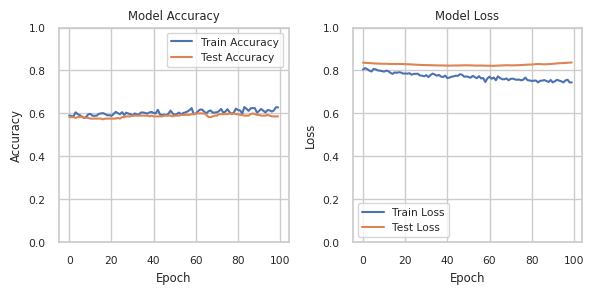

>>>>>>>>>> LR: 0.0005  | U1: 7  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3335772101425571


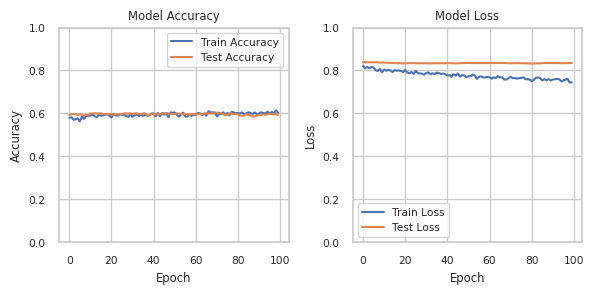

>>>>>>>>>> LR: 0.0005  | U1: 8  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3477949592561605


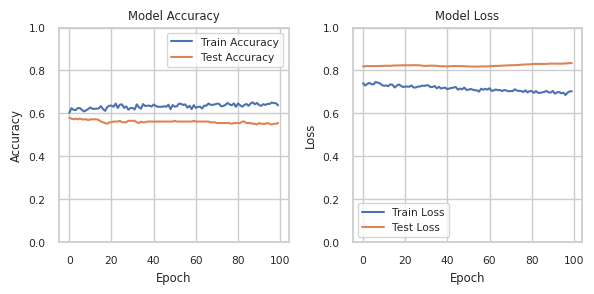

>>>>>>>>>> LR: 0.0005  | U1: 8  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3474450737593461


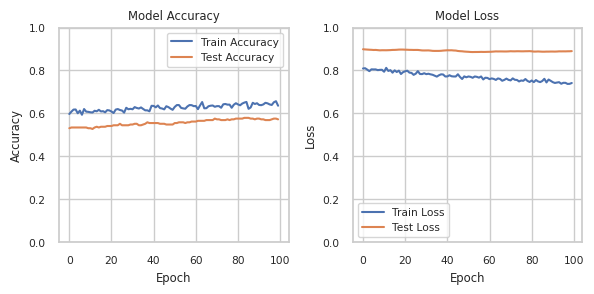

>>>>>>>>>> LR: 0.0005  | U1: 8  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.36955191300596135


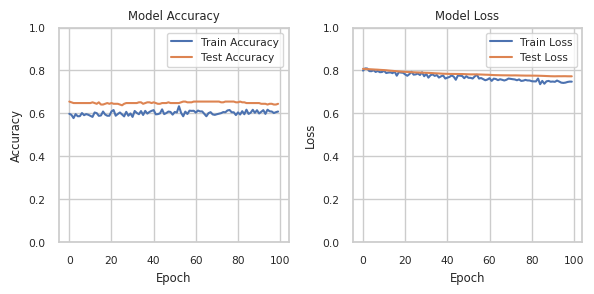

>>>>>>>>>> LR: 0.0005  | U1: 9  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3577529328574173


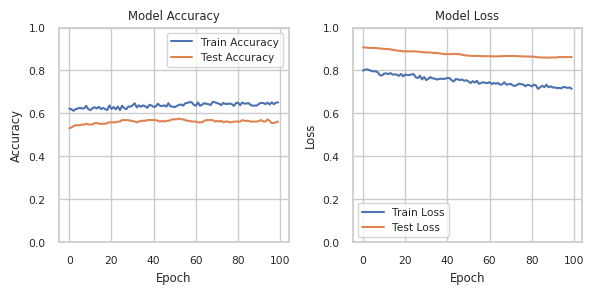

>>>>>>>>>> LR: 0.0005  | U1: 9  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3301819419064402


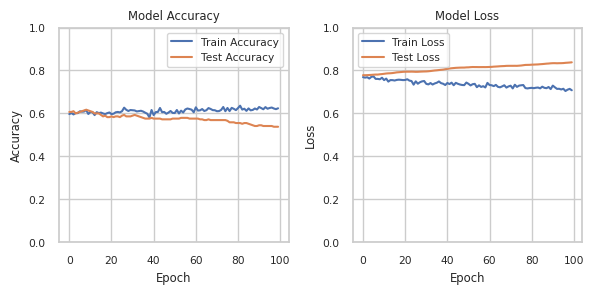

>>>>>>>>>> LR: 0.0005  | U1: 9  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3737880590478139


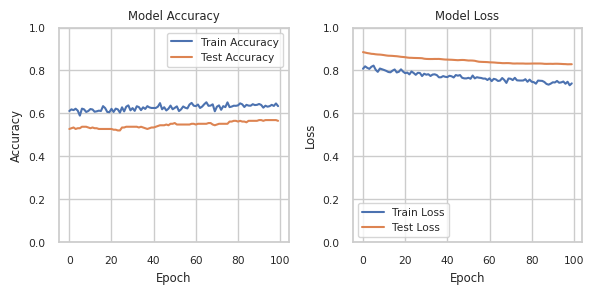

>>>>>>>>>> LR: 0.0005  | U1: 10  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.37413035002316714


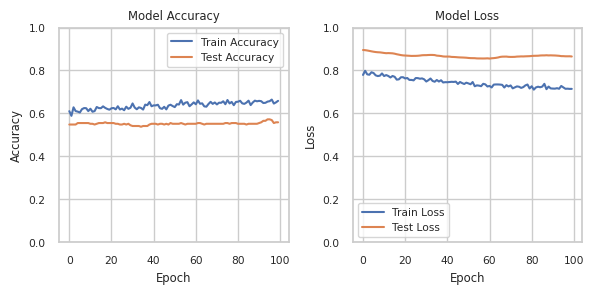

>>>>>>>>>> LR: 0.0005  | U1: 10  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.35965324273063803


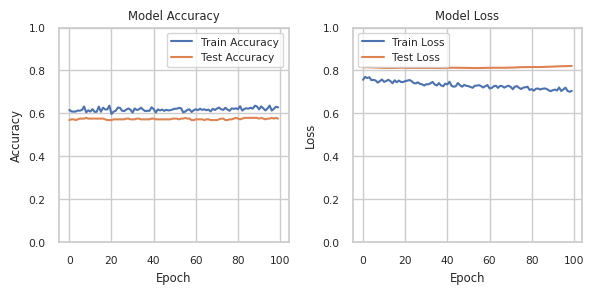

>>>>>>>>>> LR: 0.0005  | U1: 10  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3540464724371976


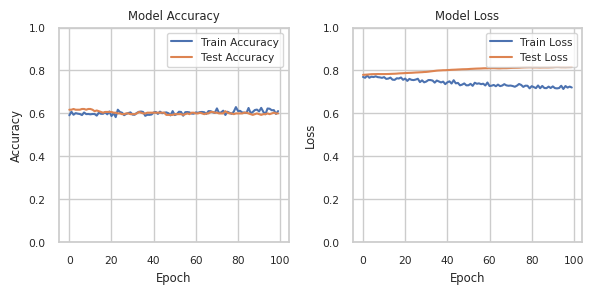

>>>>>>>>>> LR: 0.0005  | U1: 11  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3677764517107187


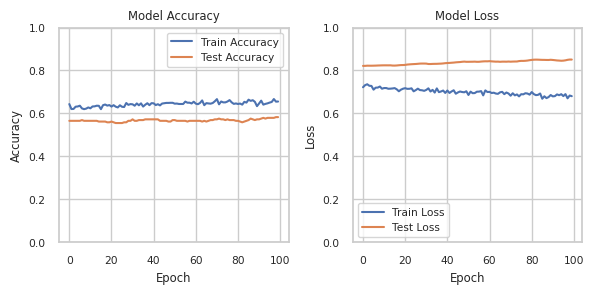

>>>>>>>>>> LR: 0.0005  | U1: 11  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3640479459870053


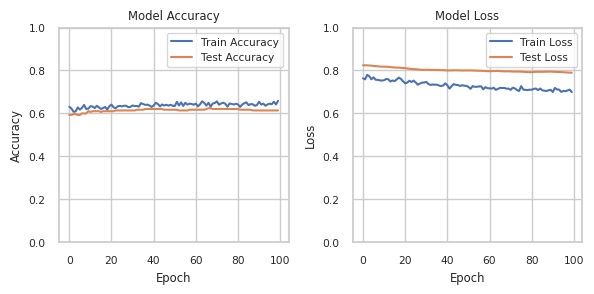

>>>>>>>>>> LR: 0.0005  | U1: 11  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.35734177890729085


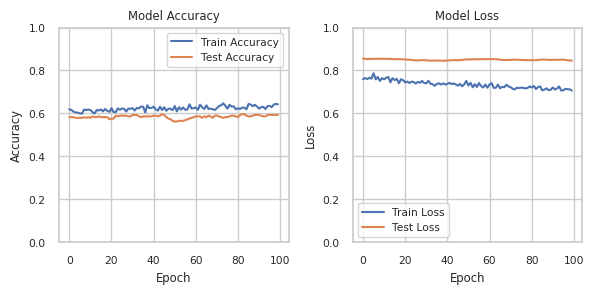

>>>>>>>>>> LR: 0.0005  | U1: 12  | DR: 0.3  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.3635607159387756


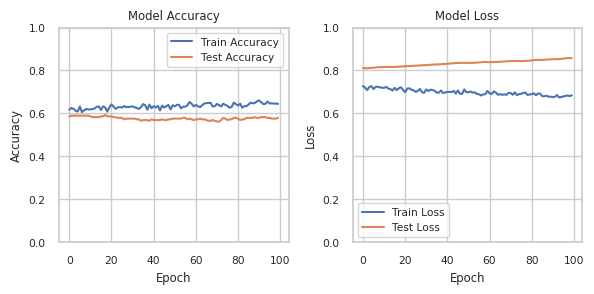

>>>>>>>>>> LR: 0.0005  | U1: 12  | DR: 0.4  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.36505137494676015


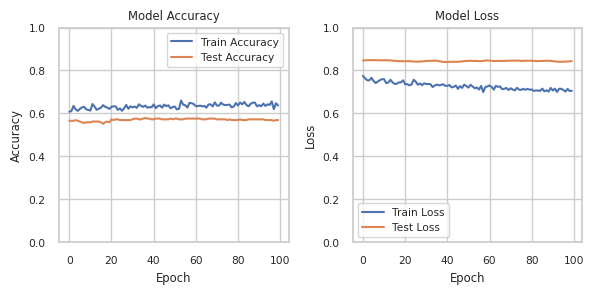

>>>>>>>>>> LR: 0.0005  | U1: 12  | DR: 0.5  | Best CV HP: {'batch_size': 360, 'epochs': 100}  | BestScore: 0.38890738576057804


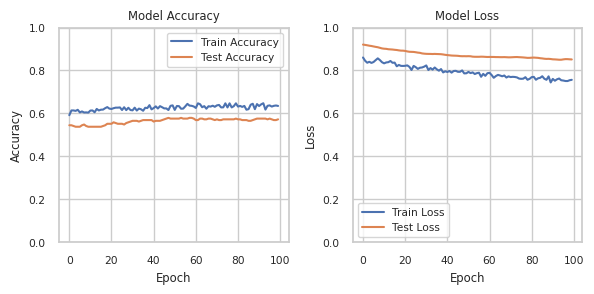

In [ ]:
# CROSS VALIDATION AND HYPERPARAMETER TUNING
# RESULTS SHOWN WITH PERSONALIZED FUNCTIONS
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994) #K FOLD STRATIFIED TO HAVE SAME TARGET DISTRIBUTION IN ALL SPLITS
model = KerasClassifier(model=create_mlp, verbose=0)

scoring = {'accuracy': 'accuracy',
           'f1_macro':'f1_macro'}

param_grid = {
    'epochs': [100],
    'batch_size': [360]
}

results=pd.DataFrame()
history_test=pd.DataFrame()

# I try different learning rates and number of neurons
for lr in [0.0005]:
    for u1 in [5,6,7,8,9,10,11,12]:
        for dr in [0.3,0.4,0.5]:
            #CV
            model = KerasClassifier(model=create_mlp(learning_rate=lr,units_d1=u1,drop_rate=dr), verbose=0)
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, scoring=scoring, refit='f1_macro')
            grid_search.fit(X_SCALED, y)
            to_Add=pd.DataFrame({"LR":[lr],"U1":[u1],"DR":[dr],
                                 "Best_CV_epochs":[grid_search.best_params_["epochs"]],
                                 "Best_CV_batch_size":[grid_search.best_params_["batch_size"]],
                                 "BestScore":grid_search.best_score_,"BestModel":grid_search.best_estimator_})
            results=pd.concat([results,to_Add],ignore_index=True)
            print(">>>>>>>>>> LR:",lr," | U1:",u1," | DR:",dr," | Best CV HP:",grid_search.best_params_," | BestScore:",grid_search.best_score_)
            #EVALUATION
            history = grid_search.best_estimator_.fit(X_SCALED, y, validation_data=(X_test_SCALED, y_test))
            history_toAdd=pd.DataFrame(history.history_)
            history_toAdd["LR"]=lr
            history_toAdd["U1"]=u1
            history_toAdd["DR"]=dr
            history_test=pd.concat([history_toAdd,history_test])
            F1_Modelling_Extra_Functions.MLP_test_results(history_toAdd,figuresize=(6,3)) #plots


Accuracy:  0.5896551724137931
F1 Score:  0.3803654908627285


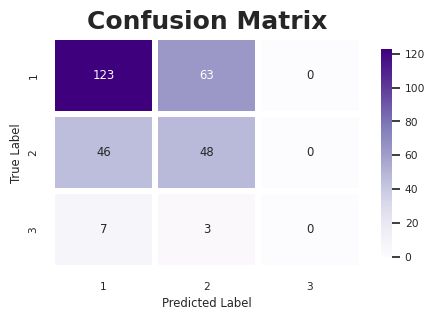

              precision    recall  f1-score   support

           1       0.70      0.66      0.68       186
           2       0.42      0.51      0.46        94
           3       0.00      0.00      0.00        10

    accuracy                           0.59       290
   macro avg       0.37      0.39      0.38       290
weighted avg       0.58      0.59      0.59       290



In [ ]:
# Try model in test set
y_pred = results[(results["U1"]==6)&(results["DR"]==0.5)].reset_index()["BestModel"][0].predict(X_test_SCALED)

# Metrics
test_accuracy = accuracy_score(y_test+1, y_pred+1)
test_f1 = f1_score(y_test+1, y_pred+1, average='macro')

# Print the results
print("Accuracy: ",test_accuracy)
print("F1 Score: ",test_f1)

F1_Modelling_Extra_Functions.classification_test_results(y_test+1,y_pred+1,figuresize=(5,3)) #confusion matrix and classification report